In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import hdbscan

In [3]:
from pathlib import  Path

In [4]:
data = pd.read_csv('../../Body/1Raw/MitoBreakDB_12122019.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 14 columns):
Deletions                          1313 non-null object
5' breakpoint                      1313 non-null object
3' breakpoint                      1313 non-null object
Deletion length - bp               1313 non-null object
Deletion of replication origins    1313 non-null object
Location of the deleted region     1313 non-null object
Single mtDNA deletions             153 non-null object
Multiple mtDNA deletions           331 non-null object
Healthy tissues                    308 non-null object
Parkinson Disease                  26 non-null object
Inclusion Body Myositis            48 non-null object
Tumour                             94 non-null object
Other clinical features            558 non-null object
References                         1313 non-null object
dtypes: object(14)
memory usage: 143.7+ KB


In [6]:
data.head()

,Deletions,5' breakpoint,3' breakpoint,Deletion length - bp,Deletion of replication origins,Location of the deleted region,Single mtDNA deletions,Multiple mtDNA deletions,Healthy tissues,Parkinson Disease,Inclusion Body Myositis,Tumour,Other clinical features,References
0,83:16095,83,16095,16011,OH and OL,Removing full minor and part o(...),NaN,Patients with pathogenic MGME1(...),NaN,NaN,NaN,NaN,NaN,[327]
1,105:112,105,112,6,None,Inside the major arc,NaN,NaN,Normal tissues (polymorphism),NaN,NaN,NaN,NaN,[53-57]
2,114:12305,114,12305,12190,OH and OL,Removing full minor and part o(...),NaN,Patients with pathogenic MGME1(...),NaN,NaN,NaN,NaN,NaN,[327]
3,167:16223,167,16223,16055,OH and OL,Removing full minor and part o(...),NaN,Patients with pathogenic MGME1(...),NaN,NaN,NaN,NaN,NaN,[327]
4,174:3623,174,3623,3448,OH,Removing part of minor and maj(...),NaN,NaN,NaN,NaN,NaN,NaN,Skeletal muscle biopsies and �(...),[329]


In [7]:
breakpoints = data[["5' breakpoint", "3' breakpoint"]][:-1].copy()

In [8]:
breakpoints.columns = ['five', 'three']

In [9]:
breakpoints.five = breakpoints.five.astype(int)
breakpoints.three = breakpoints.three.astype(int)

In [10]:
breakpoints.loc[breakpoints.five < 110, 'five'] += 16569
breakpoints.loc[breakpoints.three < 110, 'three'] += 16569

In [11]:
breakpoints = breakpoints[(breakpoints.five > 5781)&(breakpoints.three > 5781)]

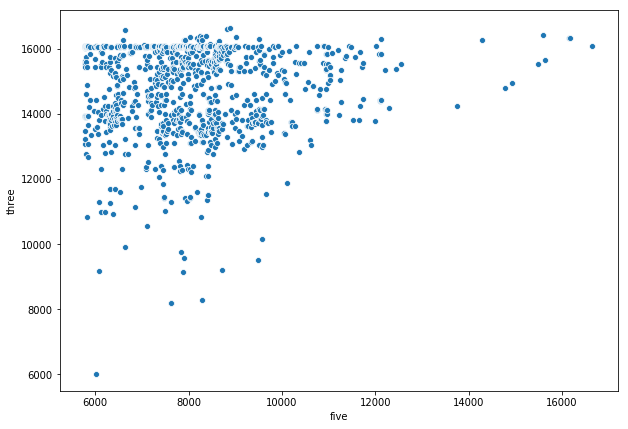

In [12]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=breakpoints, x='five', y='three')

In [13]:
def clustering(breakpoints, graph_fn = 'clusters.png'):
    clusterer = hdbscan.HDBSCAN(cluster_selection_epsilon = 50
                            #, cluster_selection_method='leaf'
                            , min_samples=10                            
                           )
    clusters  =clusterer.fit_predict(breakpoints)
    colors = sns.color_palette('hls', len(np.unique(clusters))-1)
    sns.set_style('white')
    plt.figure(figsize=(10,7))
    plt.gca().invert_yaxis()
    x = breakpoints.five[clusters == -1]
    y = breakpoints.three[clusters == -1]
    plt.scatter(x, y, color='black', alpha=0.5, s=5)

    for c, color in list(zip(range(0, np.max(clusters)+1), colors)):
        x = breakpoints.five[clusters == c]
        y = breakpoints.three[clusters == c]
        plt.scatter(x, y, color=color, s=25)
    plt.xlabel("5'")
    plt.ylabel("3'")
    plt.title('Кластеры')
    plt.savefig( graph_fn)# 
    return breakpoints, clusters

In [14]:
figures_path = Path('../../Body/4Figures/')

# Кластеры без удаления 3' на 16000:

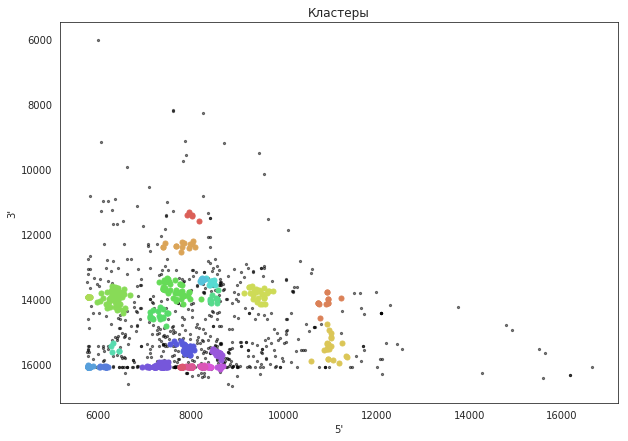

In [15]:
data, clusters = clustering(breakpoints.copy(), str(figures_path / 'clusters_with_spike.png'))

### Детальный обзор кластеров:

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


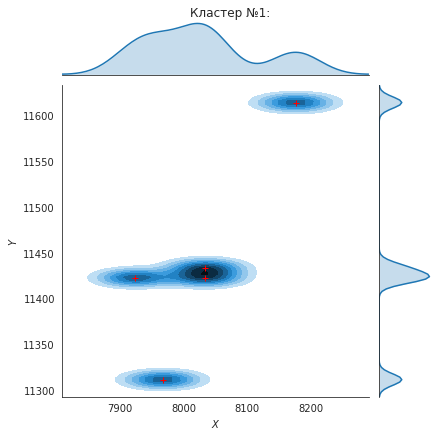

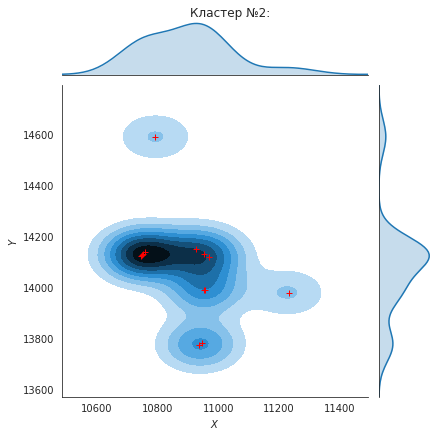

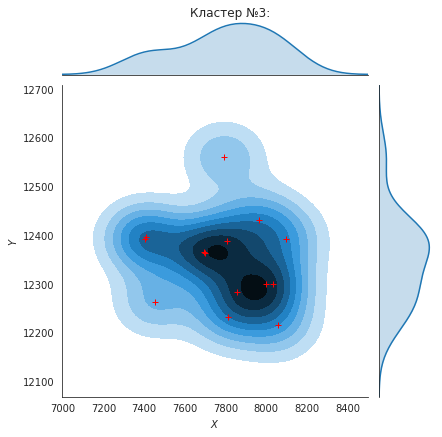

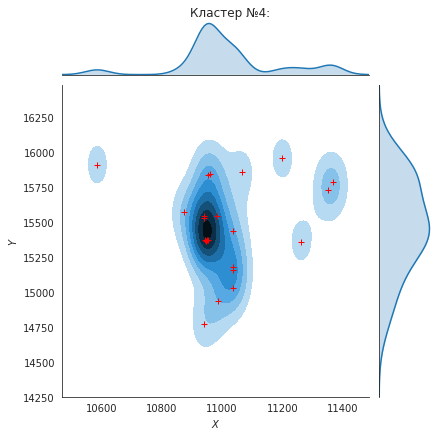

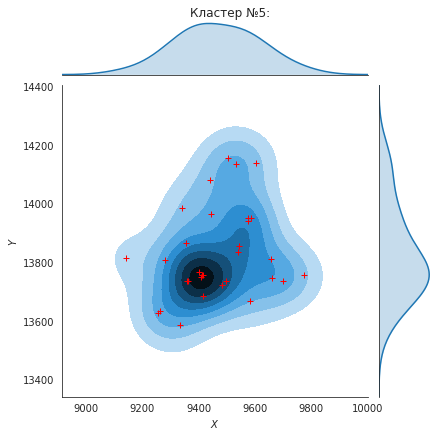

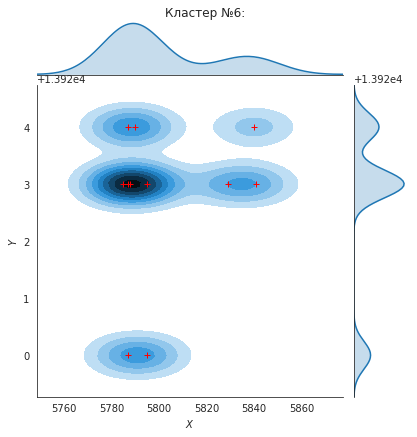

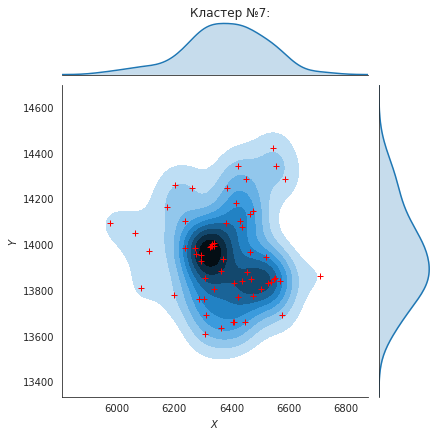

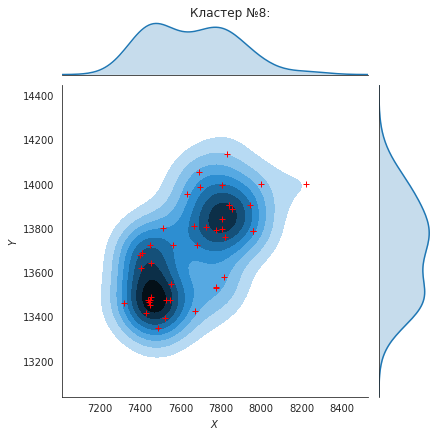

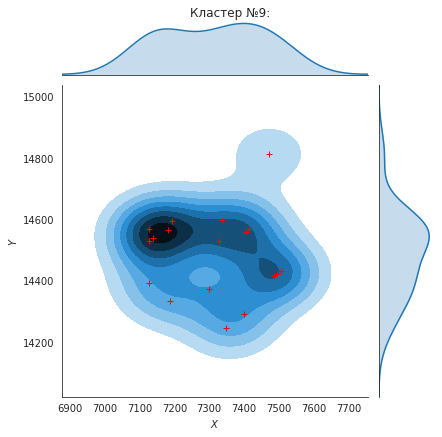

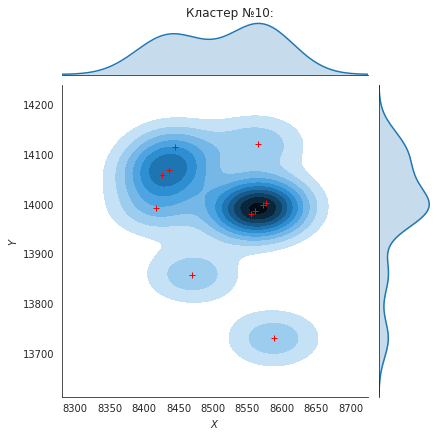

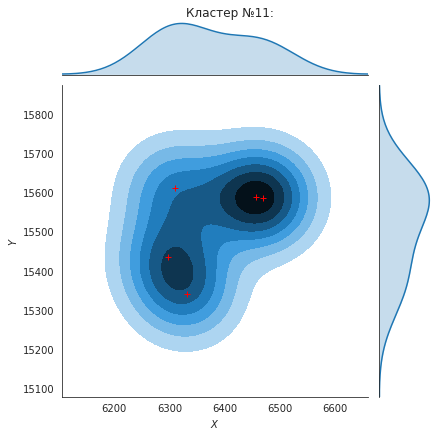

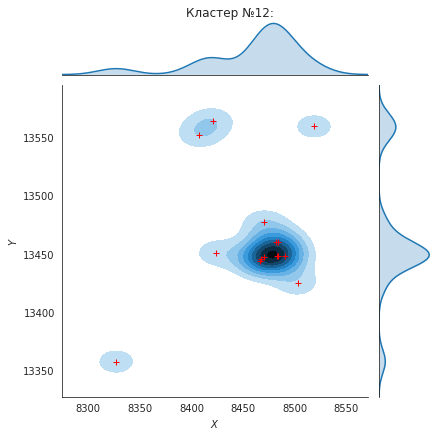

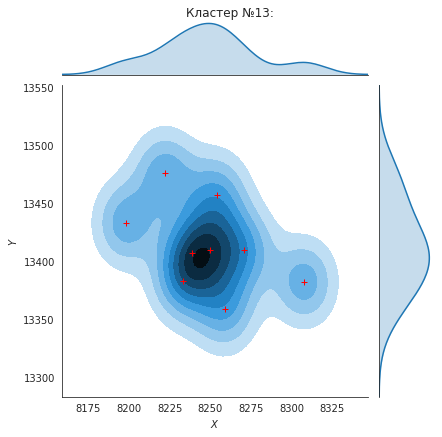

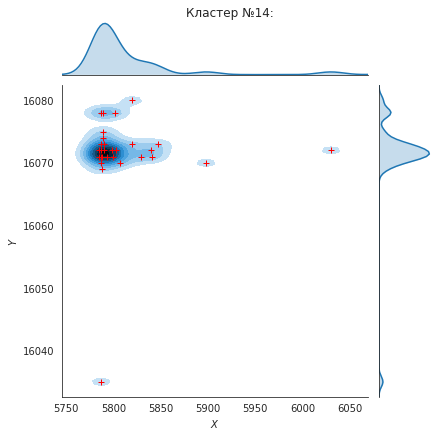

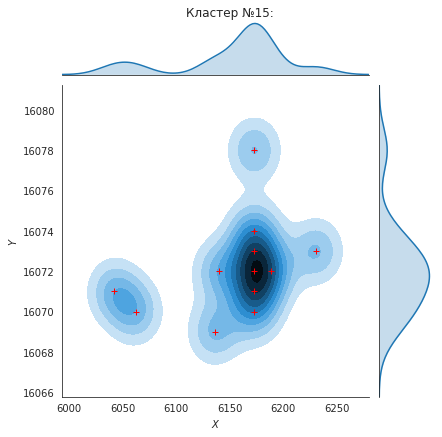

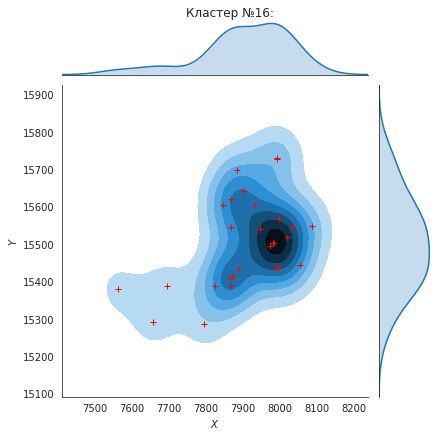

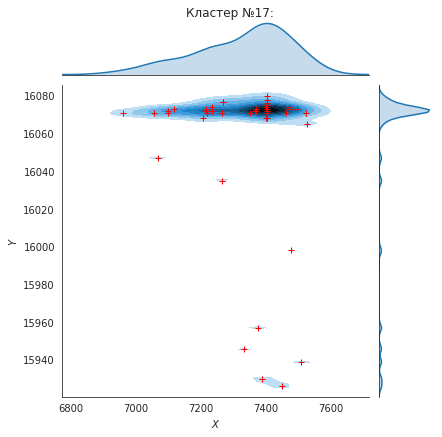

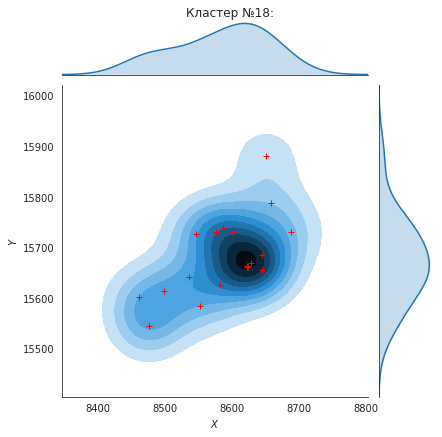

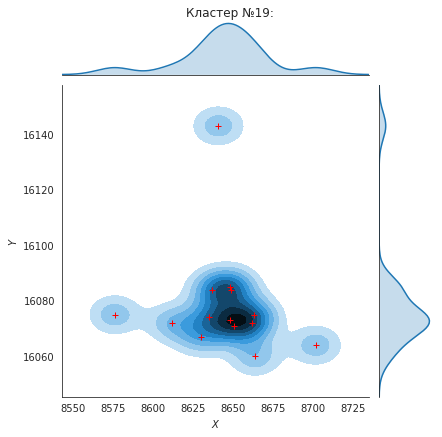

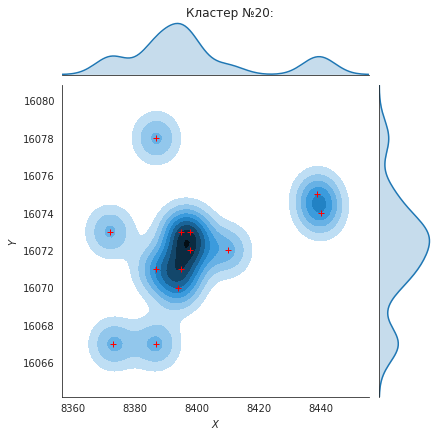

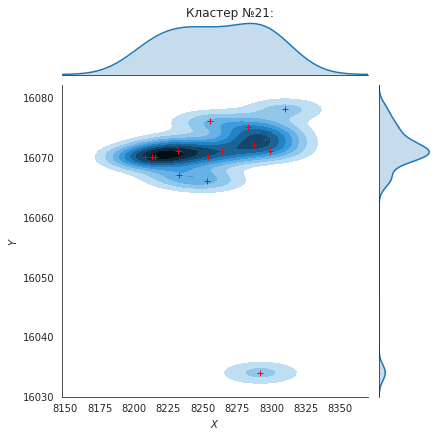

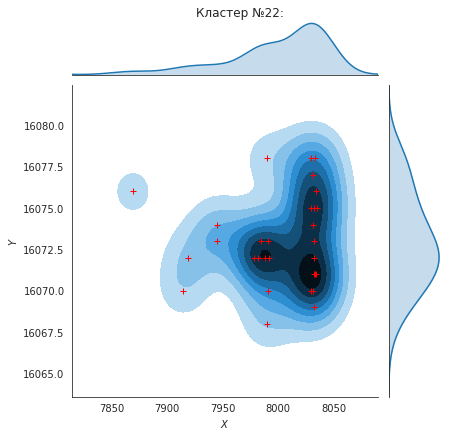

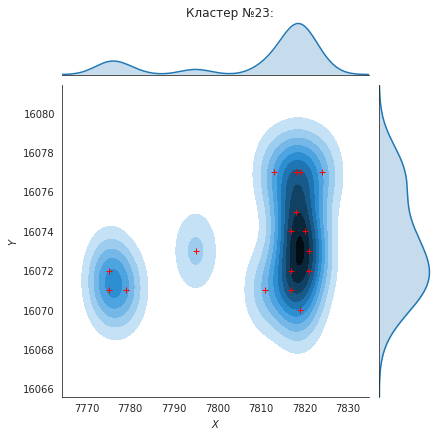

In [16]:
for c in np.unique(clusters[clusters >=0]):
    cluster_data = data[clusters == c]    
    
#     f, ax = plt.subplots(figsize=(6, 6))
#     sns.kdeplot(cluster_data.five, cluster_data.three, ax=ax)
#     #sns.jointplot(cluster_data.five, cluster_data.three, ax=ax)
#     sns.rugplot(cluster_data.five, color="g", ax=ax)
#     sns.rugplot(cluster_data.three, vertical=True, ax=ax);
    g = sns.jointplot(x="five", y="three", data=cluster_data, kind="kde")
    g.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels("$X$", "$Y$")    
    g.fig.suptitle('Кластер №{}:'.format(c+1), y= 1)
    plt.show()
    


In [17]:
data['c'] = clusters
cluster_stats = pd.concat([data[data.c >=0].groupby('c').mean(), data[data.c >=0].groupby('c').size()], axis=1)
cluster_stats.columns = ['five', 'three', 'size']
cluster_stats.to_csv(str(figures_path / '..'/ '3Results'/ 'cluster_spike_stats.csv'), index_label=None)

####  Статистика по кластерам
центры кластеров, количество элементов в кластере

In [18]:
cluster_stats

,five,three,size
c,,,
0,8026.800000,11441.200000,5
1,10897.384615,14079.615385,13
2,7791.071429,12348.857143,14
3,11015.590909,15476.818182,22
4,9466.548387,13829.322581,31
5,5802.181818,13922.727273,11
6,6377.600000,13954.750000,60
7,7655.227273,13703.250000,44
8,7309.777778,14487.666667,18


-------------
Удаление шпильки:

In [19]:
counts, bins = np.histogram(breakpoints.three, bins=100)
counts, bins = np.histogram(breakpoints[(breakpoints.three > bins[np.argmax(counts)])&(breakpoints.three < bins[np.argmax(counts)+2])].three, bins=20)
breakpoints = breakpoints[
    (breakpoints.three < bins[np.argmax(counts)]) 
    | (breakpoints.three >  bins[np.argmax(counts)+2])]

# Кластеры без "шпильки":

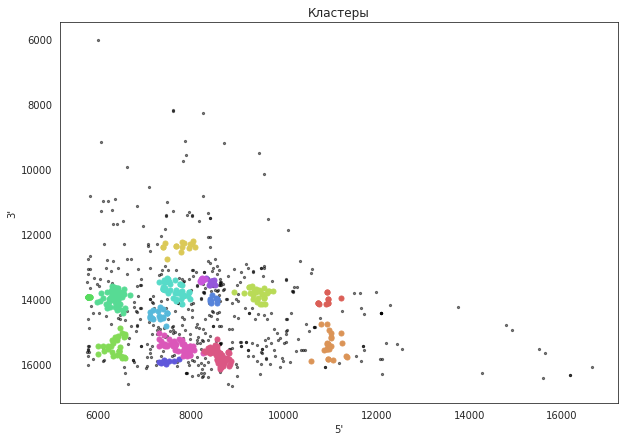

In [20]:
data2, clusters2 = clustering(breakpoints.copy(), str(figures_path / 'clusters.png'))

#### Обзор кластеров:

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


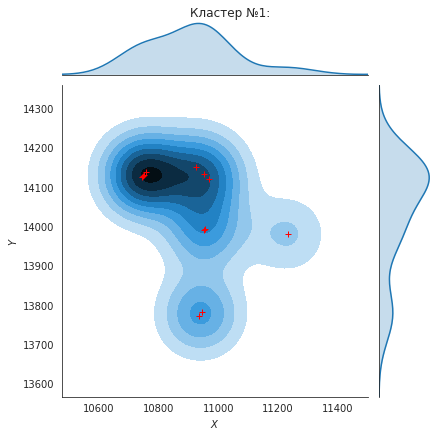

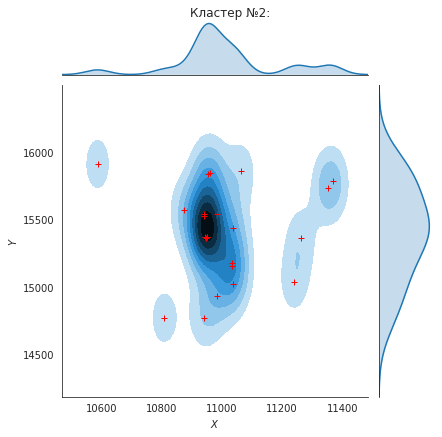

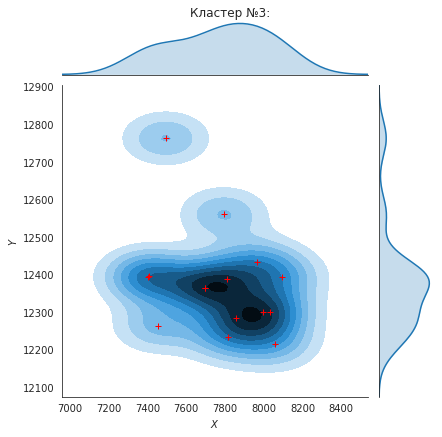

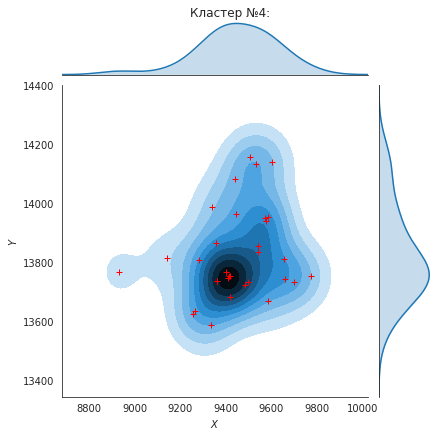

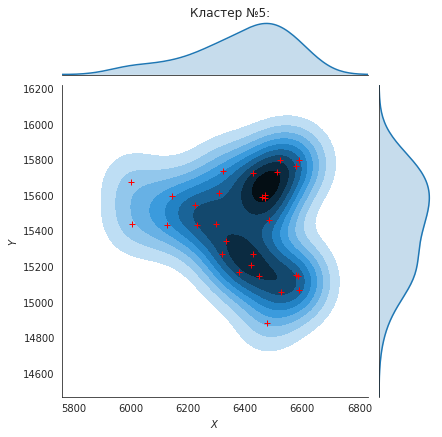

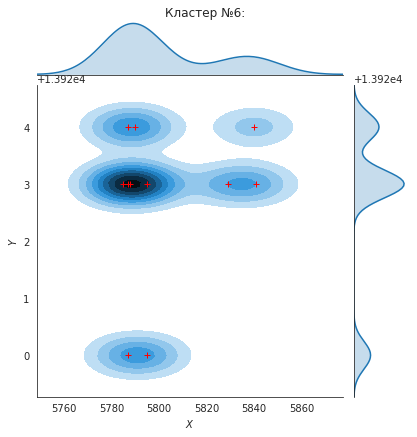

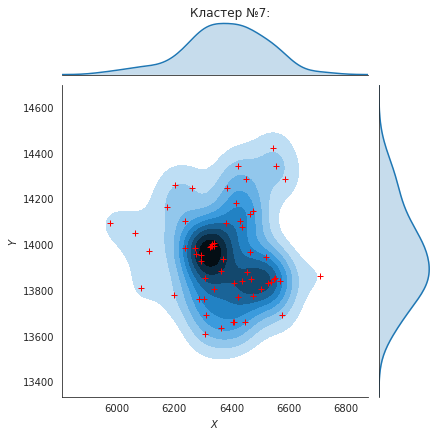

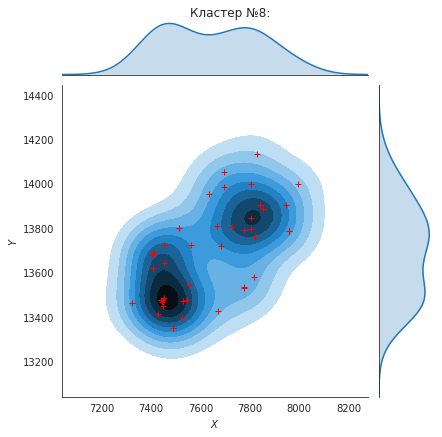

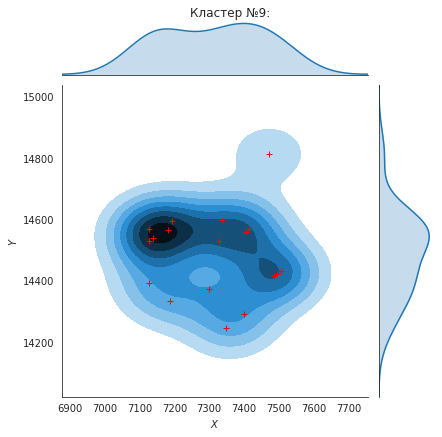

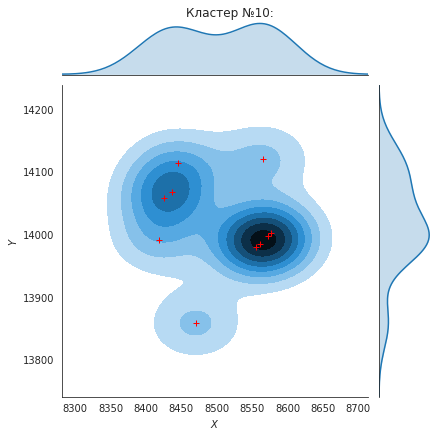

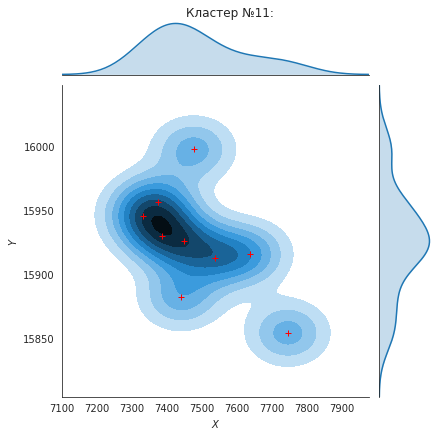

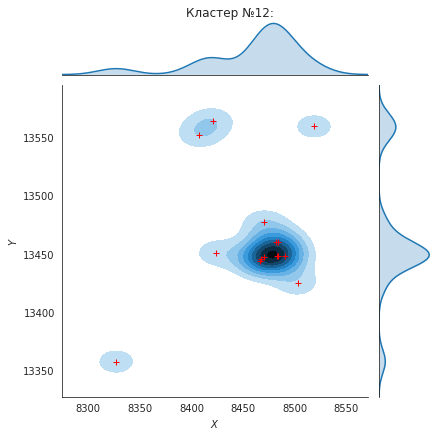

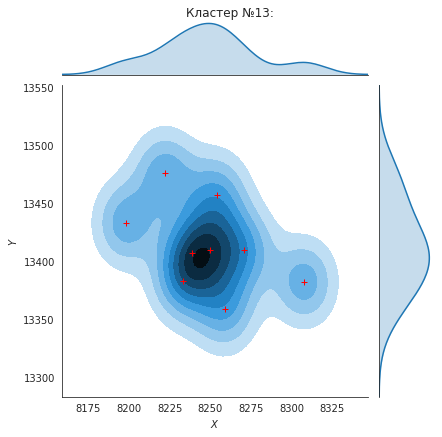

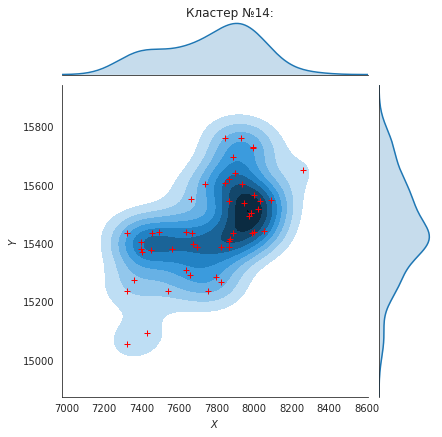

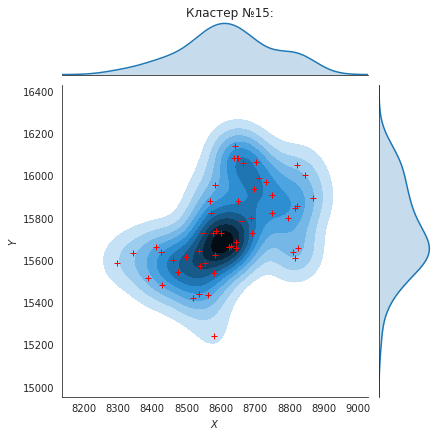

In [21]:
for c in np.unique(clusters2[clusters2 >=0]):
    cluster_data = data2[clusters2 == c]    
    
#     f, ax = plt.subplots(figsize=(6, 6))
#     sns.kdeplot(cluster_data.five, cluster_data.three, ax=ax)
#     #sns.jointplot(cluster_data.five, cluster_data.three, ax=ax)
#     sns.rugplot(cluster_data.five, color="g", ax=ax)
#     sns.rugplot(cluster_data.three, vertical=True, ax=ax);
    g = sns.jointplot(x="five", y="three", data=cluster_data, kind="kde")
    g.plot_joint(plt.scatter, c="r", s=30, linewidth=1, marker="+")
    g.ax_joint.collections[0].set_alpha(0)
    g.set_axis_labels("$X$", "$Y$")    
    g.fig.suptitle('Кластер №{}:'.format(c+1), y= 1)
    plt.show()
    


In [22]:
data2['c'] = clusters2

cluster_stats = pd.concat([data2[data2.c >=0].groupby('c').mean(), data2[data2.c >=0].groupby('c').size()], axis=1)

cluster_stats.columns = ['five', 'three', 'size']

cluster_stats.to_csv(str(figures_path / '..'/ '3Results'/ 'cluster_stats.csv'), index_label=None)

####  Статистика по кластерам
центры кластеров, количество элементов в кластере

In [23]:
cluster_stats

,five,three,size
c,,,
0,10906.083333,14036.916667,12
1,11008.304348,15406.130435,23
2,7771.266667,12376.466667,15
3,9449.875000,13827.406250,32
4,6387.931034,15437.310345,29
5,5802.181818,13922.727273,11
6,6377.600000,13954.750000,60
7,7642.093023,13696.395349,43
8,7309.777778,14487.666667,18
